In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

dist_pickle = pickle.load( open("svc_6_35_YCrCb_ALL.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = 9
pix_per_cell = 6
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 35

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes=[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = img_tosearch
    ctrans_tosearch=cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step+1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step+1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            img_features=[]
            img_features.append(spatial_features)
            img_features.append(hist_features)
            hog_features = []
            hog_features.extend(hog_feat1)
            hog_features.extend(hog_feat2)
            hog_features.extend(hog_feat3)
            hog_features = np.ravel(hog_features) 
            img_features.append(hog_features)
            img_features=np.concatenate(img_features)
            features=[]
            features.append(img_features)
            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
                
    return draw_img,boxes

ystart = 400
ystop = 656
scale = 1


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from PIL import Image
from scipy.ndimage.measurements import label
box_listall=[]
recordnum=0
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# Read in image similar to one shown above 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
def drawBox1(image,box_list):
    zero = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(zero,box_list)

    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    result = np.clip(heat, 0, 255)
#     out_image=[]
#     zero = np.zeros_like(image[:,:,0]).astype(np.float)
#     heatmap[heatmap>0]=155-heatmap[heatmap>0]*20
#     out_image.append(heatmap)
#     out_image.append(zero)
#     out_image.append(zero)
#     result=np.stack(out_image,axis=2)
    # Find final boxes from heatmap using label function
    return result
def drawBox(image,box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
imgnum=0
def mypipeline1(img):
    scale=2
    ystart=400
    ystop=656
    out_img,box1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    result=drawBox1(img,box1)
    return out_img
def mypipeline(img):
    global recordnum
    global box_listall
    scale=2
    ystart=400
    ystop=656
    boxes=[]
    out_img,box1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes.extend(box1)
    ystart=400
    ystop=528
    scale=1
    out_img,box2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes.extend(box2)
    if (recordnum<6):
        box_listall.append(boxes)
    else:
        for i in range(5):
            box_listall[i]=box_listall[i+1]
            box_listall[5]=boxes
    recordnum=recordnum+1
    box_list=[]
    for i in range(len(box_listall)):
        box_list.extend(box_listall[i])
    result=drawBox(img,box_list)
    return result
def process_image(image):
    global imgnum
    Image.fromarray(image).save('output_images1/img_ori'+str(imgnum)+'.jpg')
    image=mpimg.imread('output_images1/img_ori'+str(imgnum)+'.jpg')
    result = mypipeline(image)
    Image.fromarray(result).save('output_images1/img'+str(imgnum)+'.jpg')
    imgnum=imgnum+1
    return result


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'output_images/project_out_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_out_video.mp4
[MoviePy] Writing video output_images/project_out_video.mp4


  4%|███▍                                                                          | 56/1261 [19:45<7:11:42, 21.50s/it]

C:\Users\www\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


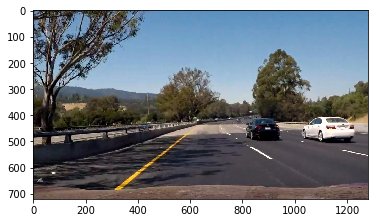

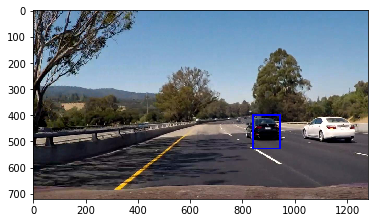

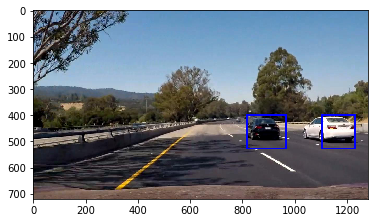

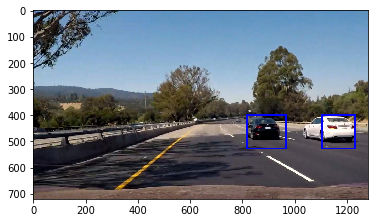

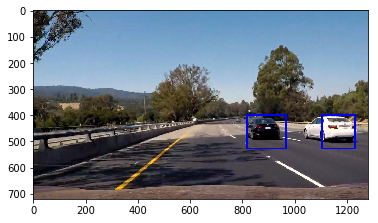

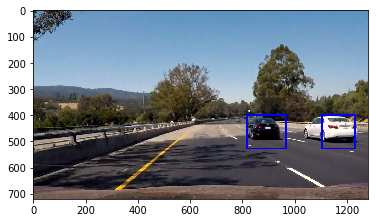

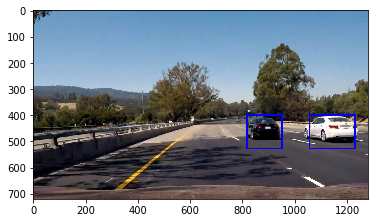

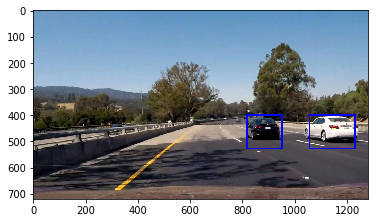

In [3]:
import matplotlib.image as mpimg
img = mpimg.imread('temp1/img21.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img22.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img23.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img24.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img25.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img26.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img27.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
img = mpimg.imread('temp1/img28.jpg')
out_img=mypipeline(img)
plt.imshow(out_img)
plt.show()
